<a href="https://colab.research.google.com/github/FahmidaAkterShimu/Final-Project-using-NLP/blob/main/Hate_Speech_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Detection using LSTM**

In [166]:
# Importing libraries
import pandas as pd
import spacy
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
df = pd.read_csv('/content/drive/MyDrive/Saved model/labeled_data.csv')

In [168]:
df.shape

(24783, 7)

In [169]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [170]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [171]:
# 1. DELETING UNWANTED COLUMNS
df.drop(columns = ['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'],
        inplace = True)

In [172]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [173]:
# 2. CHECKING FOR NULL VALUES
df.isna().sum()

,0
class,0
tweet,0


In [174]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [175]:
df['tweet'].iloc[100]

'"@ClicquotSuave: LMAOOOOOOOOOOO this nigga @Krillz_Nuh_Care http://t.co/AAnpSUjmYI" &lt;bitch want likes for some depressing shit..foh'

In [176]:
df['tweet'].iloc[1000]

'&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;"@betysweetcocker: That pussy is just....&#128561; imma assume she just had a baby like..the day before"'

In [177]:
# 3. REPLACING SYMBOLS AND NUMBERS FROM TEXT
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex = True)

In [178]:
df.head()

,class,tweet,processed_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...


In [179]:
df['processed_tweet'].iloc[1000]

'                                                                 betysweetcocker  That pussy is just              imma assume she just had a baby like  the day before '

In [180]:
# 4. REPLACING MULTIPLE WHITESPACE CHARACTERS WITH SINGLE ONE
df['processed_tweet_2'] = df['processed_tweet'].str.replace(r'[\s]+', ' ', regex = True)

In [181]:
df.head()

,class,tweet,processed_tweet,processed_tweet_2
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...,RT mayasolovely As a woman you shouldn t comp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...,RT C G Anderson viva based she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [182]:
df['processed_tweet_2'].iloc[1000]

' betysweetcocker That pussy is just imma assume she just had a baby like the day before '

In [183]:
# Deleting unwanted columns
df.drop(columns = ['tweet', 'processed_tweet'], inplace = True)

In [184]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [185]:
# 5. REPLACING THE TARGET VALUES
# df['class'].replace({0 : 'hate', 1 : 'offensive', 2 : 'neither'}, inplace = True)

In [186]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [187]:
# Load out spacy modeule
nlp = spacy.load('en_core_web_sm')

In [188]:
# 6. LEMMATIZATION
def lemmatization(text):
  doc = nlp(text)
  lemmaList = [word.lemma_ for word in doc]
  return ' '.join(lemmaList)

In [189]:
df['lemma_tweet'] = df['processed_tweet_2'].apply(lemmatization)

In [190]:
df.head()

,class,processed_tweet_2,lemma_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...


In [191]:
df['processed_tweet_2'].iloc[67]

' Allyhaaaaa Lemmie eat a Oreo amp do these dishes One oreo Lol'

In [192]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [193]:
# 7. REMOVING STOPWORDS
def remove_stopwords(text):
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return ' '.join(no_stopwords_list)

In [194]:
df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [195]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [196]:
df['final_tweet'].iloc[67]

'   Allyhaaaaa Lemmie eat Oreo amp dish oreo lol'

In [197]:
df.head()

,class,processed_tweet_2,lemma_tweet,final_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...,RT mayasolovely woman shouldn t complain cl...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad cuffin d...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...,RT UrKindOfBrand Dawg RT sbaby life fuck bi...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...,RT C G Anderson viva base look like tranny
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...,RT ShenikaRoberts shit hear true faker bitc...


In [198]:
# Lowercasing all Text
df['final_tweet'] = df['final_tweet'].str.lower()

In [199]:
# 8. ONE - HOT REPRESENTATION

vocab_size = 10000
one_hot_representation = [one_hot(words, vocab_size) for words in df['final_tweet']]

In [200]:
df['final_tweet'].iloc[0]

'   rt mayasolovely woman shouldn t complain clean house amp man trash'

In [201]:
one_hot_representation[100]

[6698,
 6458,
 259,
 7182,
 9875,
 6170,
 3543,
 9323,
 8026,
 2476,
 909,
 7045,
 3960,
 2529,
 1906,
 3844,
 7270]

In [202]:
# 9. PADDING AND EMBEDDING

sentence_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding='pre', maxlen = sentence_length)

In [203]:
embedded_tweet[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0, 2138, 4781,
       8951, 6765, 9323, 9701, 4385, 2850, 9026, 6477, 9899], dtype=int32)

In [204]:
for i in range (0,4):
  print(embedded_tweet[i])

[   0    0    0    0    0    0    0    0    0 2138 4781 8951 6765 9323
 9701 4385 2850 9026 6477 9899]
[   0    0    0    0    0    0    0 2138 6236 3565 6559 7799 2979 5134
  870 2211 6559 3240 9722 9410]
[   0    0    0    0    0    0    0    0 2138  737 5721 2138 5968 6607
 8385 7045 7122 6023 5616 3844]
[   0    0    0    0    0    0    0    0    0    0    0 2138   60 4145
 6214 7892 9102 7661 2529  419]


In [205]:
# 10. DIVIDING THE DATASET
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [206]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [207]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [208]:
# 11. TRAIN - TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [209]:
X.shape, X_train.shape, X_test.shape

((42543, 20), (34034, 20), (8509, 20))

In [210]:
# 12. CREATING MODEL

dimension = 50
vocab_size = 10000

model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(vocab_size, dimension),

    # LSTM layer
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.Dropout(0.3),  # Dropout after first LSTM

    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.Dropout(0.3),  # Dropout after second LSTM

    keras.layers.LSTM(50),
    keras.layers.Dropout(0.3),  # Dropout before final dense layer

    #output layer
    keras.layers.Dense(3, activation = 'softmax')
])

#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [211]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [212]:
# EarlyStopping + ModelCheckpoint
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Saved model/best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [213]:
# Train the Model
model.fit(
    X_train, y_train,
    validation_split=0.2,   # this is important for val_loss monitoring
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.7517 - loss: 0.5588 - val_accuracy: 0.9213 - val_loss: 0.2475
Epoch 2/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.9401 - loss: 0.1872 - val_accuracy: 0.9254 - val_loss: 0.2299
Epoch 3/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9606 - loss: 0.1291 - val_accuracy: 0.9139 - val_loss: 0.2963
Epoch 4/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.9750 - loss: 0.0915 - val_accuracy: 0.9097 - val_loss: 0.3111
Epoch 5/30
851/851 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.9791 - loss: 0.0782 - val_accuracy: 0.9029 - val_loss: 0.3672


In [224]:
# model.fit(X_train, y_train, epochs = 10, batch_size=32)

In [214]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9249 - loss: 0.2358
Model Accuracy : 92.02021360397339


In [215]:
# Save the Preprocessed Data
np.save('/content/drive/MyDrive/Saved model/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Saved model/X_test.npy', X_test)
np.save('/content/drive/MyDrive/Saved model/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Saved model/y_test.npy', y_test)

In [216]:
pred = np.argmax(model.predict(X_test), axis = -1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


In [217]:
y_test[:5]

array([1, 1, 0, 1, 2])

In [218]:
pred[:5]

array([1, 1, 0, 1, 2])

In [219]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3812
           1       0.91      0.95      0.93      3807
           2       0.84      0.76      0.80       890

    accuracy                           0.92      8509
   macro avg       0.90      0.88      0.89      8509
weighted avg       0.92      0.92      0.92      8509



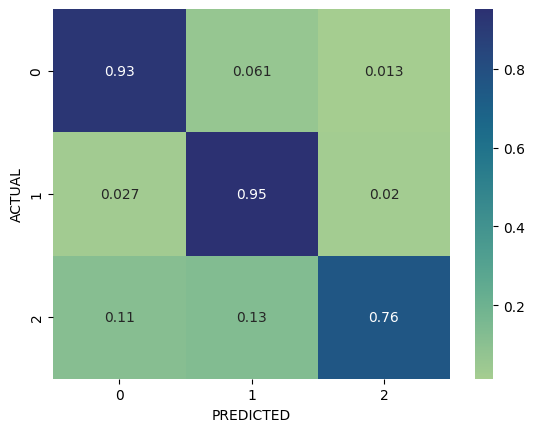

In [220]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('PREDICTED'),
plt.ylabel('ACTUAL');

In [221]:
from google.colab import drive
drive.mount('/content/drive')  # mount once

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [222]:
model.save('/content/drive/MyDrive/Saved model/my_model.keras') ### Save the model

### Before Load the Model Import all the Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # mount again for load the model

In [ ]:
# Load the Preprocessed Data
X_train = np.load('/content/drive/MyDrive/Saved model/X_train.npy')
X_test = np.load('/content/drive/MyDrive/Saved model/X_test.npy')
y_train = np.load('/content/drive/MyDrive/Saved model/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Saved model/y_test.npy')

In [ ]:
# Load the Trained/Savd Model
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Saved model/my_model.keras')

In [ ]:
#Load the Best Model Later
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Saved model/best_model.keras')

In [223]:
# Check the model accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9249 - loss: 0.2358
Model Accuracy : 92.02021360397339
